# Summary:

#### In this notebook, the trial runs from the preceding notebook ('01_So_What.ipynb') are systematically extended to try to find an optimal configuration for the two models. The model parameters to be fine tuned are: number of epochs, number of layers and the number of units.

#### The best performing model configuration will be used in the notebook '03_Blue_in_Green.ipynb' to analyze the impact of adding noise to the clean dataset.


# Table of contents
* [1. Load modules](#Part1_link)
* [2. Setup data](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1  Clean data](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2  Add noise](#Part2.2_link)
* [3. Setup models and evaluate for various hyper-parameter choices](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Compile and fit LSTM and RNN model](#Part3.1_link)
* [4. Visualize results](#Part4_link)

<a id='Part1_link'></a>
# 1. Load modules

In [1]:
import sys
sys.path.append("../src/")
import Kind_of_Blue  # own class with a collection of methods used in this analysis

import tensorflow as tf

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd


<a id='Part2_link'></a>
# 2. Setup data

<a id='Part2.1_link'></a>
### 2.1 Clean data

number of observations in time series: 1820


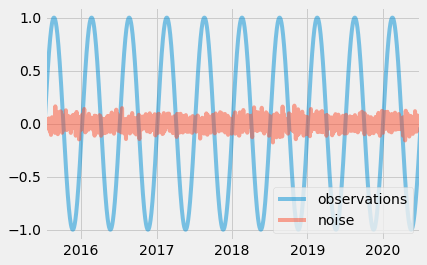

In [33]:
# set a range of dates on which the observations are made
idx = pd.date_range(end='7/1/2020', periods=5*364, freq='d')

# take a sine function as the observations
num_periods = 10  # number of sine periods
observations = [np.sin(2*np.pi*num_periods*x/len(idx)) for x in range(len(idx))]

# generate Gaussian noise

std = 0.05
mean = 0.0
noise = [np.random.normal(loc=mean, scale=std, size=None) for x in range(len(idx))]
print('number of observations in time series: {}'.format(len(observations)))

# initialize dataframe to store time series
df = pd.DataFrame(data={'observations': observations, 'noise': noise})
df.index = idx

df.plot(alpha=0.5)

The following steps are repeated from the previous notebook, '01_So_What.ipynb', and are grouped into one single step here for simplicity.

In [35]:

# initialize object
mdq = Kind_of_Blue.Kind_of_Blue()

# load dataframe into object
mdq._selected_features = ['observations', 'noise']
mdq.df = df

# train-validation split ratio as class attribute set to 70%
print('train split ratio = ', mdq.TRAIN_SPLIT_RATIO)

# initialize dataset from dataframe 
mdq.initialize_dataset()
print('loaded data set length: {}'.format(len(mdq._dataset)))

# standardize data
mdq.standardize_data()

# check that mean equals zero and the standard deviation is one
print('mean: {}, std: {}'.format(round(np.mean(mdq._dataset), 2), round(np.std(mdq._dataset), 2)))

# set number of time points for 1/ future forecasting points and 2/ the past, historical time points
future_target_size = int(365/52)
past_history_size = int(1*365)

# set batch size
batch_size = 32

# generate train and validation data
mdq.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size
                                , batch_size=batch_size)

print('number of training samples: {}'.format(mdq._num_samples))

train split ratio =  0.7
loaded data set length: 1820
mean: 0.0, std: 1.0
debug3: check what buffer_size actually does! and why is data shape always (..., ..., 1) <- 1???
training set shape: x:(909, 365, 2), y:(909, 7, 2)
validation set shape: x:(174, 365, 2), y:(174, 7, 2)
number of training samples: 909


<a id='Part3_link'></a>
# 3. Setup models and evaluate for various hyper-parameter choices

<a id='Part3.1_link'></a>
### 3.1 Compile and fit LSTM and RNN model

In [ ]:
# generator for configurations to be iterated over

def config_generator():
    
    unit_choices = [16, 32]  # number of units in each neural network layer
    layer_choices = [2, 4]  # total number of layers
    epoch_choices = [20, 50]  # number of epochs the model is trained on
    
    for units in unit_choices:
        for num_layers in layer_choices:
            for epochs in epoch_choices:
                yield units, num_layers, epochs


In [ ]:
# iterations over the model parameter configurations are done for both LSTM as well as RNN model
model_types = ['LSTM', 'RNN']

# set number of steps per epoch
num_samples = mdq._num_samples
steps_per_epoch = int(num_samples/batch_size)
validation_steps = int(steps_per_epoch/2)

# initialize results dictionary
res = {'model_type': [], 'epochs': [], 'num_layers': [], 'units': [], 'val_mse': []
       , 'mse': [], 'total_training_time': []}

for units, num_layers, epochs in config_generator():
    for model_type in model_types:

        print('currently running {} model'.format(model_type))

        # compile model
        mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)

        # fit model
        mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
                      ,validation_steps=validation_steps, model_type=model_type)
        
        # get errors
        history = mdq._histories[model_type]
        val_mse = history.history['val_mse'][-1]
        mse = history.history['mse'][-1]
        
        # get total training time
        total_training_time = sum(mdq._time_callbacks[model_type].times)
        
        # append results to results dictionary
        res['model_type'].append(model_type)
        res['epochs'].append(epochs)
        res['num_layers'].append(num_layers)
        res['units'].append(units)
        res['val_mse'].append(val_mse)
        res['mse'].append(mse)
        res['total_training_time'].append(total_training_time)


currently running LSTM model
debugLSTM: should an LSTM layer or a Dense layer be added?
Epoch 1/20
56/56 [==============================] - 27s 488ms/step - loss: 0.8151 - mse: 0.8151 - val_loss: 0.4895 - val_mse: 0.4895
Epoch 2/20
56/56 [==============================] - 25s 441ms/step - loss: 0.3843 - mse: 0.3843 - val_loss: 0.1729 - val_mse: 0.1729
Epoch 3/20
56/56 [==============================] - 24s 425ms/step - loss: 0.2212 - mse: 0.2212 - val_loss: 0.0604 - val_mse: 0.0604
Epoch 4/20
56/56 [==============================] - 24s 423ms/step - loss: 0.1521 - mse: 0.1521 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 5/20
56/56 [==============================] - 24s 427ms/step - loss: 0.1197 - mse: 0.1197 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 6/20
56/56 [==============================] - 25s 441ms/step - loss: 0.1088 - mse: 0.1088 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 7/20
56/56 [==============================] - 24s 426ms/step - loss: 0.1020 - mse: 0.1020 - val_loss: 0.0104

56/56 [==============================] - 22s 397ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 24/50
56/56 [==============================] - 27s 490ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 25/50
56/56 [==============================] - 23s 411ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 26/50
56/56 [==============================] - 26s 465ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 27/50
56/56 [==============================] - 25s 448ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 28/50
56/56 [==============================] - 25s 449ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 29/50
56/56 [==============================] - 22s 394ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 30/50
56/56 [==============================] - 23s 414ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 31/50
56/56 [=================

56/56 [==============================] - 49s 877ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 11/50
56/56 [==============================] - 50s 885ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 12/50
56/56 [==============================] - 49s 869ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 13/50
56/56 [==============================] - 49s 867ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 14/50
56/56 [==============================] - 49s 873ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 15/50
56/56 [==============================] - 48s 849ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 16/50
56/56 [==============================] - 60s 1s/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 17/50
56/56 [==============================] - 56s 1s/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 18/50
56/56 [=======================

Epoch 16/20
56/56 [==============================] - 7s 123ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 17/20
56/56 [==============================] - 7s 122ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 18/20
56/56 [==============================] - 7s 119ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 19/20
56/56 [==============================] - 7s 123ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 20/20
56/56 [==============================] - 7s 129ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0021 - val_mse: 0.0021
currently running LSTM model
debugLSTM: should an LSTM layer or a Dense layer be added?
Epoch 1/50
56/56 [==============================] - 34s 605ms/step - loss: 0.4442 - mse: 0.4442 - val_loss: 0.0851 - val_mse: 0.0851
Epoch 2/50
56/56 [==============================] - 33s 584ms/step - loss: 0.1151 - mse: 0.1151 - val_loss: 0.0228

<a id='Part4_link'></a>
# 4. Visualize results

In [ ]:
# transform dictionary to dataframe
df_res = pd.DataFrame(res)

# store dataframe as csv locally
# df_res.to_csv('../data/02_results_run2.csv')

In [ ]:
# visualize results; use bubble plots to indicate magnitude of mean-square error for specific configuration comparing
# RNN to LSTM results

x_label = 'num_layers'
y_label = 'units'
z_label = 'mse'
condition_label = 'epochs'
condition_vals = list(set(df_res[condition_label]))

condition_LSTM = (df_res['model_type']=='LSTM')
condition_RNN = (df_res['model_type']=='RNN')

for condition_val in condition_vals:
    condition_1 = (df_res[condition_label]==condition_val)
    
    x = df_res[condition_1 & condition_RNN][x_label].values
    y = df_res[condition_1 & condition_RNN][y_label].values
    
    z_RNN = df_res[condition_1 & condition_RNN][z_label].values
    z_LSTM = df_res[condition_1 & condition_LSTM][z_label].values
    plt.scatter(x, y, s=z_RNN*2000, alpha=0.5, label='RNN', c="blue", linewidth=0.0)
    plt.scatter(x, y, s=z_LSTM*2000, alpha=0.5, label='LSTM', c="red", linewidth=0.0)
        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('mean-square training error for {} epochs'.format(condition_val))
    plt.legend()
    plt.show()

In [ ]:
df_res[condition_1 & condition_RNN]#[z_label].values